### Harmonize survey results

#### Seperates the survey data into object counts, uses location and date as survey identifier.

seasonal dates: sep-november each year, april-june
water features: all lakes and rivers in the Rheine catchment area

Specifically: not including the Maass

Fetches data from the local source and esyablishes the following variables:

1. dutch_codes
2. swiss_codes
3. dutch_surveys
4. swiss_surveys
5. swiss_beaches


Establishes directory variables for fetching and putting to all subdirectories:

1. data
2. beaches
3. codes
4. geo
5. output

provides a script to update the remote data.

In [1]:
# sys things
import os
import sys
import json

# networks
import requests

# data
import pandas as pd
import numpy as np
import datetime as dt
import scipy
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML

# mapping
import geopandas as gpd

# home brew utitilties
import resources.utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# convenience functions for tables
def make_table_grids(anax):
    anax.grid(False)
    anax.spines["top"].set_visible(False)
    anax.spines["right"].set_visible(False)
    anax.spines["bottom"].set_visible(False)
    anax.spines["left"].set_visible(False)
    return(anax)

def table_fonts(a_table, size=12):
    a_table.auto_set_font_size(False)
    a_table.set_fontsize(size)

# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...
# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':14}
title_k20 = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

In [2]:
# get folder extesions
data, beaches, codes, geo, output=ut.make_local_paths()
print("look for resources here\n")
print(data, beaches, codes, geo, output)

look for resources here

resources/surveydata resources/locationdata resources/mlwcodedefs resources/geodata output


In [3]:
project_directory = ut.make_project_folder(output, "harmonized_results")
print("put stuff here:\n")
print(project_directory)

put stuff here:

output/harmonized_results


In [4]:
# survey_data
dutch_surveys = pd.read_csv(data+'/dataset_macrolitter_NL.csv')

# use the aggregated hd data. This accounts for the custom codes used in Switzerland
swiss_surveys = pd.read_csv(data+'/aggregated_hd_surveys.csv')

# location data
swiss_beaches = pd.read_csv(beaches+'/hammerdirt_beaches.csv')

In [5]:
print("Columns from cleaned up dutch data\n")
print(dutch_surveys.columns)

print("\nColumns from cleaned up swiss data\n")
print(swiss_surveys.columns)

Columns from cleaned up dutch data

Index(['Unnamed: 0', 'Gebiedscode', 'Rivier', 'Coordinaten', 'Lat', 'Lon',
       'meting', 'date', 'doy', 'dop',
       ...
       'sanitair_tissues_wc_papier', 'sanitair_toiletverfrissers',
       'sanitair_overig_sanitair', 'medisch_verpakkingen', 'medisch_spuiten',
       'medisch_overig_medisch', 'Unnamed: 121', 'Totaal', 'Items/km',
       'granulaat_korrels'],
      dtype='object', length=125)

Columns from cleaned up swiss data

Index(['loc_date', 'code', 'date', 'pcs_m', 'quantity', 'location',
       'water_name'],
      dtype='object')


In [6]:
print("the first ten rows are admin data\n")
print(dutch_surveys.columns[:10])
print("\nthe next 115 is code data\n")
print(dutch_surveys.columns[10:])
print("\none row is equal to one survey")

the first ten rows are admin data

Index(['Unnamed: 0', 'Gebiedscode', 'Rivier', 'Coordinaten', 'Lat', 'Lon',
       'meting', 'date', 'doy', 'dop'],
      dtype='object')

the next 115 is code data

Index(['plastic_6_packringen', 'plastic_tassen',
       'plastic_kleine_plastic_tasjes',
       'plastic_drankflessen_groterdan_halveliter',
       'plastic_drankflessen_kleinerdan_halveliter',
       'plastic_wikkels_van_drankflessen',
       'plastic_verpakking_van_schoonmaakmiddelen',
       'plastic_voedselverpakkingen_frietbakjes_etc',
       'plastic_cosmeticaverpakkingen',
       'plastic_motorolieverpakking_groterdan50cm',
       ...
       'sanitair_tissues_wc_papier', 'sanitair_toiletverfrissers',
       'sanitair_overig_sanitair', 'medisch_verpakkingen', 'medisch_spuiten',
       'medisch_overig_medisch', 'Unnamed: 121', 'Totaal', 'Items/km',
       'granulaat_korrels'],
      dtype='object', length=115)

one row is equal to one survey


In [7]:
print("This is the number of rows\n")
print(len(dutch_surveys))
print("\nThis is the number of unique 'Gebiedscode' values\n")
print(len(dutch_surveys.Gebiedscode.unique()))

This is the number of rows

391

This is the number of unique 'Gebiedscode' values

212


In [8]:
# key the Gebiedscode to an int
count_gebied = {n:i+1 for i,n in enumerate(dutch_surveys.Gebiedscode.unique())}

# grab only the object count columns and the river
obj_counts = dutch_surveys.columns[10:-4]

In [9]:
dutch_surveys['new date'] = dutch_surveys.date.map(lambda x: F"{x}")

def make_this_a_date(x):
    a_date = F"{x}"
    if len(a_date) == 8:
        new_date = F"{a_date[:4]}-{a_date[4:6]}-{a_date[6:]}"
        try:
            a_date = dt.datetime.strptime(new_date, "%Y-%m-%d").date()
        except:
            a_date = 'nothing'
    else:
        a_date = 'nothing'
        
    return a_date

dutch_surveys['this date'] = dutch_surveys['new date'].map(lambda x: make_this_a_date(x))
no_date_dutch_surveys =dutch_surveys[dutch_surveys['this date'] == 'nothing'].copy()
dutch_surveys = dutch_surveys[dutch_surveys['this date'] != 'nothing'].copy()
dutch_surveys['date'] = dutch_surveys['this date']

print("The date is best in an ISO standard")
dutch_surveys['this date']

The date is best in an ISO standard


0      2017-10-21
1      2017-11-03
2      2017-10-16
3      2017-10-04
4      2017-10-02
          ...    
386    2019-02-28
387    2019-03-10
388    2019-03-16
389    2019-03-03
390    2019-03-06
Name: this date, Length: 384, dtype: object

In [10]:
dutch_surveys['lat_lon'] = list(zip(dutch_surveys.Lat, dutch_surveys.Lon))
count_lat_lon = {n:i+1 for i,n in enumerate(dutch_surveys.lat_lon.unique())}
# dutch_surveys = dutch_surveys[dutch_surveys.Rivier == 'Maas']
print("The number of unique lat/lon pairs\n")
print(dutch_surveys.lat_lon.nunique())
print("\nThe number of unique lat values\n")
print(len(dutch_surveys.Lat.unique()))
print("\nThe number of unique lon values\n")
print(len(dutch_surveys.Lon.unique()))

The number of unique lat/lon pairs

192

The number of unique lat values

187

The number of unique lon values

190


In [11]:
# these columns are admin data
admin = ['lat_lon', 'Gebiedscode', 'Rivier', 'Coordinaten','Lat', 'Lon', 'meting']
date = ['date']

# unique id per row:
loc_date = ['lat_lon', 'date']

# these are no longer needed
no_longer_needed = ['Unnamed: 121', 'Totaal', 'Items/km', 'granulaat_korrels']



def make_location_groups(x, keys):
    try:
        name = keys[x]
    except:
        name = x
    return F"{name}"

# make a column of the keys created for Gebiedscode
dutch_surveys['name'] = dutch_surveys.lat_lon.map(lambda x: make_location_groups(x, count_lat_lon))
dutch_surveys['name'] = dutch_surveys.Rivier + dutch_surveys.name


# zip that up with the date
dutch_surveys['loc_date'] = list(zip(dutch_surveys['new date'], dutch_surveys.lat_lon))
# dutch_surveys['loc_date'] = dutch_surveys.loc_date.map(lambda x: F"{x}")

# make an admin df:
dutch_admin = dutch_surveys[['name',*admin]]
a_file_name = F"{project_directory}/dutch_admin_h.csv"
dutch_admin.to_csv(a_file_name)

print("This is the admin data plus a name tag and a lat_lon tag\n")
dutch_admin.iloc[:5]

This is the admin data plus a name tag and a lat_lon tag



,name,lat_lon,Gebiedscode,Rivier,Coordinaten,Lat,Lon,meting
0,Waal1,"(51.8227, 5.0159)",W(078a)R-ZHNL,Waal,#REF!,51.8227,5.0159,0
1,Waal2,"(51.82899999999999, 5.0805)",W(074b)R-REFE,Waal,#REF!,51.8290,5.0805,0
2,Waal3,"(51.8126, 5.2358)",W(062a)L-GENL,Waal,#REF!,51.8126,5.2358,0
3,Waal4,"(51.8475, 5.4159)",W(048a)L-GENL,Waal,#REF!,51.8475,5.4159,0
4,Waal5,"(51.8588, 5.4222)",W(046a)L-GENL,Waal,#REF!,51.8588,5.4222,0


In [12]:
dutch_admin.name.unique()

array(['Waal1', 'Waal2', 'Waal3', 'Waal4', 'Waal5', 'Waal6', 'Waal7',
       'Waal8', 'Waal9', 'Waal10', 'Waal11', 'Waal12', 'Waal13', 'Maas14',
       'Maas15', 'Waal16', 'Maas17', 'Waal18', 'Waal19', 'Waal20',
       'Waal21', 'Waal22', 'Waal23', 'Waal24', 'Waal25', 'Waal26',
       'Waal27', 'Waal28', 'Waal29', 'Waal30', 'Waal31', 'Waal32',
       'Waal33', 'Waal34', 'Waal35', 'Waal36', 'Waal37', 'Waal38',
       'Waal39', 'Nederrijn13', 'Maas40', 'Maas41', 'Maas42', 'Maas43',
       'Maas44', 'Maas45', 'Maas46', 'Maas47', 'Maas48', 'Maas49',
       'Maas50', 'Maas51', 'Maas52', 'Maas53', 'Maas54', 'Maas55',
       'Maas56', 'Maas57', 'Maas58', 'Maas59', 'Maas60', 'Maas61',
       'Maas62', 'Maas63', 'Maas64', 'Maas65', 'Maas66', 'Maas67',
       'Maas68', 'Maas69', 'Maas70', 'Maas71', 'Maas72', 'Maas73',
       'Maas74', 'Maas75', 'Maas76', 'Maas77', 'Maas78', 'Maas79',
       'Maas80', 'Maas81', 'Maas82', 'Maas83', 'Maas84', 'Maas85',
       'Maas86', 'Maas87', 'Maas88', 'Maas89',

In [13]:
print("This is one record:\n")
dutch_admin.iloc[0]

This is one record:



name                       Waal1
lat_lon        (51.8227, 5.0159)
Gebiedscode        W(078a)R-ZHNL
Rivier                      Waal
Coordinaten                #REF!
Lat                      51.8227
Lon                       5.0159
meting                         0
Name: 0, dtype: object

In [14]:
print("\nSerach by lat/lon combination\n")
dutch_admin[dutch_admin.lat_lon == (51.8588, 5.4222)]


Serach by lat/lon combination



,name,lat_lon,Gebiedscode,Rivier,Coordinaten,Lat,Lon,meting
4,Waal5,"(51.8588, 5.4222)",W(046a)L-GENL,Waal,#REF!,51.8588,5.4222,0
34,Waal5,"(51.8588, 5.4222)",W(046a)L-GENL,Waal,#REF!,51.8588,5.4222,1
151,Waal5,"(51.8588, 5.4222)",W(046a)L-GENL,Waal,#REF!,51.8588,5.4222,2


In [15]:
# a place to store the results
new_results=[]

def seperate_results(x, a_list):
    # alist is the list of columns to keep
    # return x because we don't want to chage the df
    for element in a_list:
        stuff = {'name':x['name'], 'date':x['date'], 'loc_date':x['loc_date'], 'river':x['Rivier'], 'object':element, 'quantity':x[element] }
        new_results.append(stuff)
    return x

# apply

dutch_surveys.apply(lambda row: seperate_results(row, obj_counts), axis=1)

# make new df 
a_results_df = pd.DataFrame(new_results)
a_results_df['date'] = pd.to_datetime(a_results_df['date'], format='%Y-%m-%d')

a_file_name = F"{project_directory}/dutch_surveys_h.csv"
a_results_df.to_csv(a_file_name)

print()
print("This is the object results with a  name tag and a loc_date tag\n")
a_results_df[a_results_df.name == 'Waal8'][:10]


This is the object results with a  name tag and a loc_date tag



,name,date,loc_date,river,object,quantity
777,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_6_packringen,0.0
778,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_tassen,0.0
779,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_kleine_plastic_tasjes,1.0
780,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_drankflessen_groterdan_halveliter,0.0
781,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_drankflessen_kleinerdan_halveliter,2.0
782,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_wikkels_van_drankflessen,0.0
783,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_verpakking_van_schoonmaakmiddelen,1.0
784,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_voedselverpakkingen_frietbakjes_etc,0.0
785,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_cosmeticaverpakkingen,0.0
786,Waal8,2017-10-11,"(20171011, (51.8923, 5.5114))",Waal,plastic_motorolieverpakking_groterdan50cm,0.0


In [16]:
print("The total by loc_date\n")
print(a_results_df.groupby(['name', 'loc_date']).quantity.sum())

The total by loc_date

name     loc_date                     
Maas100  (20180222, (51.1469, 5.8794))     166.0
         (20181113, (51.1469, 5.8794))     156.0
         (20190228, (51.1469, 5.8794))     260.0
Maas101  (20180219, (51.1307, 5.8417))    1090.0
         (20190223, (51.1307, 5.8417))     453.0
                                           ...  
Waal8    (20181006, (51.8923, 5.5114))     152.0
         (20190225, (51.8923, 5.5114))     197.0
Waal9    (20171002, (51.8897, 5.5208))     195.0
         (20180416, (51.8897, 5.5208))     196.0
         (20190306, (51.8897, 5.5208))     376.0
Name: quantity, Length: 382, dtype: float64


In [17]:
print("The total by river\n")
print(a_results_df.groupby('river').quantity.sum())

The total by river

river
Maas         113043.0
Nederrijn      7279.0
Waal          30684.0
Name: quantity, dtype: float64


In [18]:
print("The total quantity\n")
print(a_results_df.quantity.sum())

The total quantity

151006.0


In [19]:
tops = a_results_df.groupby(['object']).quantity.sum()
tops = tops.sort_values(ascending=False)

print("The top ten objects:\n")
print(tops[:10])

The top ten objects:

object
plastic_plastic_stukjes_2_5_50cm_zacht_plastic    24023.0
plastic_plastic_stukjes_0_2_5cm_zacht_plastic     18008.0
plastic_piepschuim_0_2_5cm                        14944.0
plastic_snoep_snack_chipsverpakking               10587.0
plastic_piepschuim_2_5_50cm                       10558.0
plastic_plastic_stukjes_0_2_5cm_hard_plastic       9278.0
plastic_plastic_stukjes_2_5_50cm_hard_plastic      7581.0
plastic_doppen_en_deksels                          6923.0
plastic_voedselverpakkingen_frietbakjes_etc        3608.0
sanitair_plastic_wattenstaafjes                    3242.0
Name: quantity, dtype: float64


In [20]:
# the column names need to be harmonized:
print(a_results_df.columns)
print(swiss_surveys.columns)

Index(['name', 'date', 'loc_date', 'river', 'object', 'quantity'], dtype='object')
Index(['loc_date', 'code', 'date', 'pcs_m', 'quantity', 'location',
       'water_name'],
      dtype='object')


In [21]:
# renaming the columns
a_results_df.rename(columns={'name':'location', 'river':'water_name', 'object':'code'}, inplace=True)
a_results_df['pcs_m'] = a_results_df.quantity/100
a_results_df['pcs_m'] = a_results_df.pcs_m.round(3)

In [22]:
swiss_surveys.water_name.unique()

array(['Zurichsee', 'Aare', 'Aare|Nidau-Büren-Kanal', 'Lac Léman', 'Arve',
       'Lago Maggiore', 'Thunersee', 'Untersee', 'Bielersee', 'Birs',
       'Bodensee', 'Chriesbach', 'Emme', 'Neuenburgersee', 'Walensee',
       'Glatt', 'Goldach', 'Greifensee', 'Grändelbach', 'Brienzersee',
       'Inn', 'Jona', 'Katzensee', 'Dorfbach', 'La Thièle', 'Langeten',
       'Rhône', 'Limmat', 'Linthkanal', 'Escherkanal', 'Lorze',
       'Lötschebach', 'Murg', 'Ognonnaz', 'Pfaffnern', 'Reuss', 'Rhein',
       'Maggia', 'Schiffenensee', 'Schüss', 'Seez', 'Sempachsee', 'Sense',
       'Sihl', 'Sihlsee', 'Sitter', 'Thur', 'Töss', 'Urnäsch',
       'Quatre Cantons', 'Vorderrhein', 'Zugersee', 'Zulg'], dtype=object)

In [23]:
a_min_date = a_results_df['date'].min()
a_max_date = a_results_df['date'].max()
print(a_min_date, a_max_date)

# rivers in switzerland
water_names = ['Aare', 'Sihl', 'Reuss', 'Rhein', 'Limmat', 'Seez','Zurichsee','Quatre Cantons', 'Vorderrhein', 'Zugersee','Glatt', 'Goldach', 'Greifensee','Bodensee', 'Chriesbach', 'Emme', 'Neuenburgersee', 'Walensee' ]

swiss_surveys['date'] = pd.to_datetime(swiss_surveys['date'], format='%Y-%m-%d')
swissDf = swiss_surveys[(swiss_surveys.date >= a_min_date)&(swiss_surveys.date <= a_max_date)].copy()

swissDfx = swissDf[swissDf.water_name.isin(water_names)].copy()
survey_total_ch = swissDfx.groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
# a_results_df['date'] = pd.to_datetime(a_results_df['date'], format='%Y-%m-%d')
survey_total_ch['month'] =survey_total_ch['date'].dt.month 
print("summary stats for the swiss survey totals:\n")
survey_total_ch.pcs_m.describe()

2017-07-04 00:00:00 2019-04-24 00:00:00
summary stats for the swiss survey totals:



count    395.000000
mean       1.934987
std        3.015470
min        0.010000
25%        0.345000
50%        0.990000
75%        2.115000
max       28.140000
Name: pcs_m, dtype: float64

In [24]:
a_results_dfx = a_results_df.groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'}).copy()
a_results_dfx['month'] =a_results_dfx['date'].dt.month 

print("summary stats for the dutch survey totals:\n")
a_results_dfx.pcs_m.describe()

summary stats for the dutch survey totals:



count    382.000000
mean       3.953037
std        7.535271
min        0.020000
25%        1.012500
50%        2.050000
75%        3.845000
max       88.920000
Name: pcs_m, dtype: float64

In [25]:
a_min_date.date()

datetime.date(2017, 7, 4)

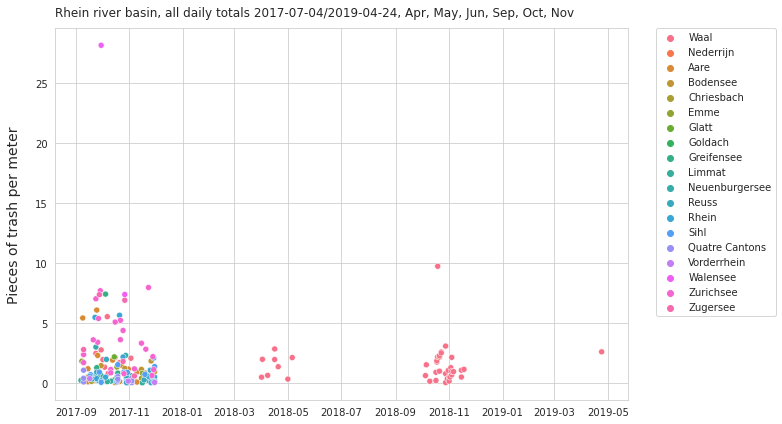

In [26]:
sns.set_style('whitegrid')

a_results_dfx['country'] = 'nl'
survey_total_ch['country'] = 'ch'

daily_totals = pd.concat([a_results_dfx, survey_total_ch])

data = daily_totals[daily_totals.month.isin([9,10,11,4,5,6])]
data = data[data.water_name != 'Maas']

fig, ax = plt.subplots(figsize=(11,6))

sns.scatterplot(data=data, x='date', y='pcs_m', hue='water_name', palette='husl', ax=ax)

ax.set_title(F"Rhein river basin, all daily totals {a_min_date.date()}/{a_max_date.date()}, Apr, May, Jun, Sep, Oct, Nov", **title_k)
ax.set_ylabel("Pieces of trash per meter", **ylab_k)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
a_name = F"{project_directory}/initial_harmonized_results.jpg"
plt.savefig(a_name, dpi=300)

plt.show()
plt.close()


### These are the unaccounted for dutch surveys (no date):

In [27]:
no_date_dutch_surveys

,Unnamed: 0,Gebiedscode,Rivier,Coordinaten,Lat,Lon,meting,date,doy,dop,...,sanitair_overig_sanitair,medisch_verpakkingen,medisch_spuiten,medisch_overig_medisch,Unnamed: 121,Totaal,Items/km,granulaat_korrels,new date,this date
153,155,W(042a)L-GENL,Waal,#REF!,51.8872,5.4663,2,0,NaN,NaN,...,0,0,0,0,NaN,55,550,0,0,nothing
155,157,W(038a)L-GENL,Waal,#REF!,51.8897,5.5208,2,0,NaN,NaN,...,1,0,0,0,NaN,143,1430,0,0,nothing
181,184,M(122a)L-NBNL,Maas,#REF!,51.7444,5.3194,2,0,NaN,NaN,...,0,0,0,0,NaN,256,2560,1,0,nothing
246,259,W(039a)L-GENL,Waal,#REF!,51.8876,5.4978,3,0,NaN,NaN,...,0,0,0,0,NaN,336,3360,0,0,nothing
270,285,W(008a)L-GENL,Waal,#REF!,51.7183,4.6980,3,0,NaN,NaN,...,0,0,0,0,NaN,106,1060,4,0,nothing
288,303,M(149a)L-NBNL,Maas,#REF!,51.7175,4.9081,3,0,NaN,NaN,...,0,0,0,0,NaN,103,1030,0,0,nothing
383,400,M(009a)R-LINL,Maas,#REF!,50.9022,5.6980,3,0,NaN,NaN,...,0,4,0,0,NaN,410,4100,0,0,nothing


### Change the object definitions to OSPAR codes

The objects definitions need to changed to OSPAR

In [28]:
## !!! refresh the data from the hammerdirt api here:

# a = requests.get('https://mwshovel.pythonanywhere.com/api/surveys/daily-totals/code-totals/swiss/')
# b = requests.get('https://mwshovel.pythonanywhere.com/api/list-of-beaches/swiss/')
# c = requests.get('https://mwshovel.pythonanywhere.com/api/mlw-codes/list/')

# # the surveys need to be unpacked:
# swiss_surveys = ut.unpack_survey_results(a.json())
# swiss_surveys = pd.DataFrame(swiss_surveys)

# # adding location date column
# swiss_surveys['loc_date'] = list(zip(swiss_surveys['location'], swiss_surveys['date']))

# # hold the original
# x = a.json()

# print("survey columns")
# print(swiss_surveys.columns)

# swiss_beaches = pd.DataFrame(b.json())
# print("beach columns")
# print(swiss_beaches.columns)

# print("code columns")
# swiss_codes = pd.DataFrame(c.json())
# print(swiss_codes.columns)

# swiss_surveys.to_csv(data+'/hammerdirt_data.csv')
# swiss_beaches.to_csv(beaches+'/hammerdirt_beaches.csv')
# swiss_codes.to_csv(codes+'/swiss_codes.csv')
